            +------------+     +---------------+     +-----------+
            | user_data  |     | post_text_df  |     | feed_data |
            +------------+     +---------------+     +-----------+
            | age        |     | id            |     | timestamp |
            | city       |     | text          |     | user_id   |
            | country    |     | topic         |     | post_id   |
            | exp_group  |     +---------------+     | action    |
            | gender     |           7,023           | target    |
            | id         |                           +-----------+
            | os         |                             76,892,800
            | source     |
            +------------+
                163,205 

# Data Preprocessing

In [7]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [8]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

# Чтение данных таблицы user_data
query = "SELECT * FROM user_data"
user_data = pd.read_sql(query, engine)

# Чтение данных таблицы post_text_df
query = "SELECT * FROM post_text_df"
post_text_df = pd.read_sql(query, engine)

# Чтение ограниченного количества данных таблицы feed_data
query = "SELECT * FROM feed_data LIMIT 100000"
feed_data = pd.read_sql(query, engine)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle


In [10]:
# Переименование столбцов идентификаторов
user_data = user_data.rename(columns={'id': 'user_id'})
post_text_df = post_text_df.rename(columns={'id': 'post_id'})

# Объединение таблиц
data = feed_data.merge(user_data, on='user_id', how='left')
data = data.merge(post_text_df, on='post_id', how='left')


In [11]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-12-18 12:13:53,91263,6814,view,0,0,14,Russia,Krasnouralsk,3,Android,ads,Ive seen this programme a few times and the mo...,movie
1,2021-12-18 12:15:58,91263,2753,view,0,0,14,Russia,Krasnouralsk,3,Android,ads,@JackMa did you just hear what happened to you...,covid
2,2021-12-18 12:17:19,91263,4804,view,0,0,14,Russia,Krasnouralsk,3,Android,ads,Im disappointed that Reiser (who wrote the fil...,movie
3,2021-12-18 12:19:54,91263,441,view,0,0,14,Russia,Krasnouralsk,3,Android,ads,McDonalds boss Bell dies aged 44\n\nCharlie Be...,business
4,2021-12-18 12:20:52,91263,6659,view,0,0,14,Russia,Krasnouralsk,3,Android,ads,This film is not at all as bad as some people ...,movie


# Ferauture engineering

### Time
Here we will create 3 new feautures from the timestamp:
1. hour_of_day
2. time_since_last_action
3. day_of_week

In [12]:
import pandas as pd

# Convert the timestamp format to a datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract features from the timestamp
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour

# Calculate the time since the last action for each user
data = data.sort_values(['user_id', 'timestamp'])
data['time_since_last_action'] = data.groupby('user_id')['timestamp'].diff().dt.total_seconds()
data['time_since_last_action'].fillna(0, inplace=True)


In [13]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic,day_of_week,hour_of_day,time_since_last_action
148,2021-11-08 18:11:36,5399,4604,view,0,1,19,Russia,Salsk,1,Android,ads,Although I agree that its a good but not great...,movie,0,18,0.0
149,2021-11-08 18:14:21,5399,255,view,0,1,19,Russia,Salsk,1,Android,ads,Warning over US pensions deficit\n\nTaxpayers ...,business,0,18,165.0
150,2021-11-08 18:15:47,5399,3129,view,0,1,19,Russia,Salsk,1,Android,ads,Sad &amp; pathetic. \n\n#RevolvingDoorOfCorrup...,covid,0,18,86.0
151,2021-11-08 18:18:04,5399,6813,view,0,1,19,Russia,Salsk,1,Android,ads,"its been awhile since ive seen Cold Mountain,b...",movie,0,18,137.0
152,2021-11-08 18:19:50,5399,6708,view,1,1,19,Russia,Salsk,1,Android,ads,"Its a road movie, with a killer on-board. Bria...",movie,0,18,106.0


### One hot encoding

In [14]:
# One-hot encoding for 'country', 'city', and 'topic'
data = pd.get_dummies(data, columns=['country', 'city', 'topic'], prefix=['country', 'city', 'topic'])

In [15]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,city_Yuzhno-Sakhalinsk,city_Zaporizhzhia,city_Zhukovka,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
148,2021-11-08 18:11:36,5399,4604,view,0,1,19,1,Android,ads,...,0,0,0,0,0,0,1,0,0,0
149,2021-11-08 18:14:21,5399,255,view,0,1,19,1,Android,ads,...,0,0,0,1,0,0,0,0,0,0
150,2021-11-08 18:15:47,5399,3129,view,0,1,19,1,Android,ads,...,0,0,0,0,1,0,0,0,0,0
151,2021-11-08 18:18:04,5399,6813,view,0,1,19,1,Android,ads,...,0,0,0,0,0,0,1,0,0,0
152,2021-11-08 18:19:50,5399,6708,view,1,1,19,1,Android,ads,...,0,0,0,0,0,0,1,0,0,0


### Label encoding

In [16]:
from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
le_os = LabelEncoder()
le_source = LabelEncoder()
le_action = LabelEncoder()

# Label encoding for 'gender', 'os', and 'source'
data['gender'] = le_gender.fit_transform(data['gender'])
data['os'] = le_os.fit_transform(data['os'])
data['source'] = le_source.fit_transform(data['source'])
data['action'] = le_action.fit_transform(data['action'])


In [17]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,city_Yuzhno-Sakhalinsk,city_Zaporizhzhia,city_Zhukovka,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
148,2021-11-08 18:11:36,5399,4604,1,0,1,19,1,0,0,...,0,0,0,0,0,0,1,0,0,0
149,2021-11-08 18:14:21,5399,255,1,0,1,19,1,0,0,...,0,0,0,1,0,0,0,0,0,0
150,2021-11-08 18:15:47,5399,3129,1,0,1,19,1,0,0,...,0,0,0,0,1,0,0,0,0,0
151,2021-11-08 18:18:04,5399,6813,1,0,1,19,1,0,0,...,0,0,0,0,0,0,1,0,0,0
152,2021-11-08 18:19:50,5399,6708,1,1,1,19,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [18]:
# check data type of each column
print(data.dtypes)

timestamp              datetime64[ns]
user_id                         int64
post_id                         int64
action                          int64
target                          int64
                            ...      
topic_entertainment             uint8
topic_movie                     uint8
topic_politics                  uint8
topic_sport                     uint8
topic_tech                      uint8
Length: 172, dtype: object


идеи для создания новых признаков:

1. Количество просмотров и лайков для каждого пользователя.
2. Количество просмотров и лайков для каждого поста.
3. Среднее время между просмотрами для каждого пользователя.
4. Доля лайков от просмотров для каждого пользователя и поста.
5. Количество просмотров и лайков для каждой темы.
6. Количество просмотров и лайков для каждой операционной системы и источника трафика.
7. Доля просмотров и лайков для каждой темы от общего числа просмотров и лайков пользователя.

### Количество просмотров и лайков для каждого пользователя, os, source, topic

In [19]:
# Feature 1: Количество просмотров и лайков для каждого пользователя
user_views_likes = data.groupby('user_id')['action'].value_counts().unstack().fillna(0)
user_views_likes.columns = ['user_views', 'user_likes']
data = data.merge(user_views_likes, on='user_id', how='left')

# Feature 2: Количество просмотров и лайков для каждого поста
post_views_likes = data.groupby('post_id')['action'].value_counts().unstack().fillna(0)
post_views_likes.columns = ['post_views', 'post_likes']
data = data.merge(post_views_likes, on='post_id', how='left')


In [20]:
temp_df = data[['exp_group', 'topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech', 'action']]
for col in ['topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech']:
    temp_df[col] = temp_df[col] * temp_df['action']
grouped_data = temp_df.groupby('exp_group').sum().reset_index()
grouped_data.columns = ['exp_group'] + [f'{col}_exp_group_views' if i % 2 == 0 else f'{col}_exp_group_likes' for i, col in enumerate(grouped_data.columns[1:], 1)]
data = data.merge(grouped_data, on='exp_group', how='left')


/var/folders/6v/_xvyw44141s6_68z7m_2yyp80000gn/T/ipykernel_54798/2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[col] = temp_df[col] * temp_df['action']


In [21]:
# print the list of columns
print(data.columns.tolist())

['timestamp', 'user_id', 'post_id', 'action', 'target', 'gender', 'age', 'exp_group', 'os', 'source', 'text', 'day_of_week', 'hour_of_day', 'time_since_last_action', 'country_Belarus', 'country_Finland', 'country_Kazakhstan', 'country_Russia', 'country_Turkey', 'country_Ukraine', 'city_Achikulak', 'city_Achinsk', 'city_Agryz', 'city_Almaty', 'city_Almazna', 'city_Arkhangelsk', 'city_Asbest', 'city_Astrakhan', 'city_Balakovo', 'city_Barnaul', 'city_Baymak', 'city_Belokurikha', 'city_Benoy', 'city_Bor', 'city_Borisov', 'city_Borovichi', 'city_Bryansk', 'city_Budënnovsk', 'city_Cheboksary', 'city_Chernogorsk', 'city_Derbent', 'city_Desnogorsk', 'city_Donskoy', 'city_Dubovka', 'city_Dyurtyuli', 'city_Engels', 'city_Gatchina', 'city_Gorodishche', 'city_Groznyy', 'city_Gubkin', 'city_Gukovo', 'city_Homyel’', 'city_Ivanovo', 'city_Izhevsk', 'city_Iğdır', 'city_Kalach-na-Donu', 'city_Kaliningrad', 'city_Kazan', 'city_Kemerovo', 'city_Khabarovsk', 'city_Khasavyurt', 'city_Khrustalnyi', 'city_Ki

## Text features extraction

We will keep it simple and use the most lightweight approach - TF-IDF together with some basic text preprocessing.

1. Text statistics: You can use custom functions to compute the following statistics:
    - Number of words
    - Number of sentences
    - Average word length
    - Punctuation count
2. BoW or TF-IDF: Use either `CountVectorizer` or `TfidfVectorizer` from scikit-learn, and set the `max_features` parameter to limit the vocabulary size. This will help to control the dimensionality of the resulting feature matrix and keep the model lightweight.

In [22]:
import numpy as np
import re
from string import punctuation

def word_count(X):
    return np.array([len(re.findall(r'\b\w+\b', text)) for text in X])

def sentence_count(X):
    return np.array([len(re.findall(r'[.!?]+', text)) for text in X])

def avg_word_length(X):
    return np.array([sum(len(word) for word in re.findall(r'\b\w+\b', text)) / len(re.findall(r'\b\w+\b', text)) if len(re.findall(r'\b\w+\b', text)) > 0 else 0 for text in X])

def punctuation_count(X):
    return np.array([sum(1 for char in text if char in punctuation) for text in X])


In [23]:

# Apply the feature extraction functions to the 'text' column
word_counts = word_count(data['text'])
sentence_counts = sentence_count(data['text'])
avg_word_lengths = avg_word_length(data['text'])
punctuation_counts = punctuation_count(data['text'])

# Add the new features as columns in the DataFrame
data['word_count'] = word_counts
data['sentence_count'] = sentence_counts
data['avg_word_length'] = avg_word_lengths
data['punctuation_count'] = punctuation_counts


After running the model again on the mutual information to extract the top 30, 

In [24]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,exp_group,os,source,...,topic_entertainment_exp_group_likes,topic_movie_exp_group_views,topic_politics_exp_group_likes,topic_sport_exp_group_views,topic_tech_exp_group_likes,action_exp_group_views,word_count,sentence_count,avg_word_length,punctuation_count
0,2021-11-08 18:11:36,5399,4604,1,0,1,19,1,0,0,...,890,6306,1686,2209,656,16897,160,5,4.300000,22
1,2021-11-08 18:14:21,5399,255,1,0,1,19,1,0,0,...,890,6306,1686,2209,656,16897,280,13,4.846429,36
2,2021-11-08 18:15:47,5399,3129,1,0,1,19,1,0,0,...,890,6306,1686,2209,656,16897,10,2,10.800000,11
3,2021-11-08 18:18:04,5399,6813,1,0,1,19,1,0,0,...,890,6306,1686,2209,656,16897,149,14,4.167785,23
4,2021-11-08 18:19:50,5399,6708,1,1,1,19,1,0,0,...,890,6306,1686,2209,656,16897,413,22,4.878935,94


## Feauture selection

### Pearson's Correlation Coefficient
We will discard this method because it is not suitable for categorical features.

### Mutual Information
We will choose this method because it is suitable for both categorical and numerical features.

In [28]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Assume `data` is your DataFrame with features and target
X = data.drop(['target', 'timestamp', 'text'], axis=1)
y = data['target']

# Calculate mutual information between each feature and the target variable
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame with feature names and their corresponding MI scores
mi_scores_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})

# Sort the DataFrame by MI scores in descending order
mi_scores_df = mi_scores_df.sort_values('mi_score', ascending=False)

# Optionally, select the top k features using SelectKBest
k = 30
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

print("Top k features based on mutual information:")
print(selected_features)


Top k features based on mutual information:
Index(['user_id', 'action', 'gender', 'age', 'exp_group', 'os', 'source',
       'day_of_week', 'hour_of_day', 'time_since_last_action',
       'country_Russia', 'city_Almazna', 'city_Groznyy', 'city_Saratov',
       'city_Trosna', 'city_Yershov', 'topic_covid', 'topic_movie',
       'topic_tech', 'user_views', 'user_likes', 'post_views',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views'],
      dtype='object')


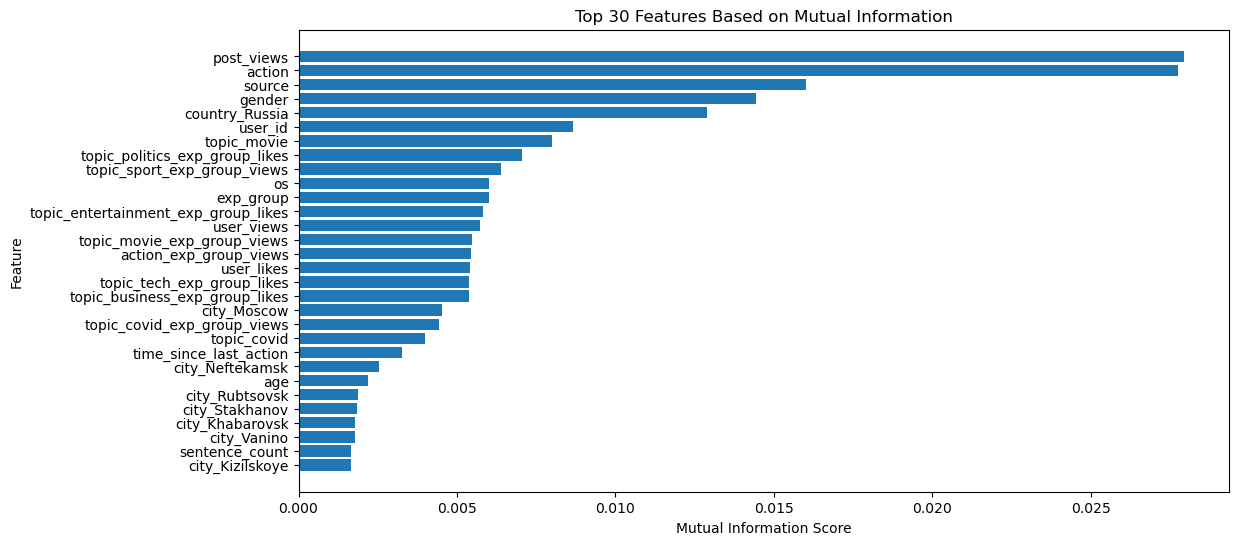

In [29]:
import matplotlib.pyplot as plt

# Set the number of top features to display
top_k = 30

# Get the top k features
top_k_features = mi_scores_df.head(top_k)

# Plot the top k features
plt.figure(figsize=(12, 6))
plt.barh(top_k_features['feature'], top_k_features['mi_score'], align='center')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top {} Features Based on Mutual Information'.format(top_k))
plt.gca().invert_yaxis()
plt.show()


# Model engineering

## Data preprocessing

We will use only the following features that we selected (`selected_features`) using the mutual information method:
`
'user_id', 'action', 'gender', 'age', 'exp_group', 'os', 'source',
       'day_of_week', 'time_since_last_action', 'country_Russia',
       'city_Kamyshlov', 'city_Moscow', 'city_Polatsk', 'city_Simferopol',
       'city_Tegul’det', 'city_Vyborg', 'topic_covid', 'topic_movie',
       'user_views', 'user_likes', 'post_views', 'post_likes',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views'`

In [30]:
df_top_k = data[selected_features]

# split the data into train and test
from sklearn.model_selection import train_test_split

X = df_top_k
y = data['target']

# Splitting 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data scaling

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  Model selection

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Initialize the models
logreg = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42)

# List of models for easy iteration
models = [logreg, rf, xgb]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']

# Perform cross-validation and print the average accuracy for each model
for name, model in zip(model_names, models):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{name} average accuracy: {cv_scores.mean():.4f}')


Logistic Regression average accuracy: 0.8920
Random Forest average accuracy: 0.8792
XGBoost average accuracy: 0.8894


We can say that top 30 feautures worked better than 100 feautures.
Logistic regression showed the best results.

# Optimization

Our implementation of Hitrate@5 metric.

In [33]:
def hit_rate_at_k(actual, predicted, k=5):
    if len(actual) == 0:
        return np.nan
    hits = 0
    total_predictions = len(predicted)
    
    for i in range(total_predictions):
        if actual[i] in predicted[i][:k]:
            hits += 1

    return hits / total_predictions


In [34]:
from sklearn.metrics import make_scorer

def hit_rate_scorer(y_true, y_pred, k=5):
    hit_rates = []
    for user_id in np.unique(y_true[:, 0]):
        actual = y_true[y_true[:, 0] == user_id, 1]
        predicted = y_pred[y_true[:, 0] == user_id, 1]
        hit_rates.append(hit_rate_at_k(actual, predicted, k))

    return np.nanmean(hit_rates)

custom_scorer = make_scorer(hit_rate_scorer, greater_is_better=True, needs_proba=True)


In [35]:
# Fit each model and predict probabilities for the test set
logreg.fit(X_train, y_train)
logreg_probs = logreg.predict_proba(X_test)

rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)

xgb.fit(X_train, y_train)
xgb_probs = xgb.predict_proba(X_test)


In [41]:
def get_top_k_predictions(probs, k=5):
    top_k_preds = np.argsort(probs, axis=1)[:, -k:]
    return top_k_preds

logreg_top_5_preds = get_top_k_predictions(logreg_probs)
rf_top_5_preds = get_top_k_predictions(rf_probs)
xgb_top_5_preds = get_top_k_predictions(xgb_probs)


In [43]:
y_test_true = np.array([y_test])


In [45]:
def hit_rate_at_k(actual, predicted, k):
    if len(actual) == 0:
        return np.nan
    hits = 0
    total_predictions = len(actual)
    for i in range(total_predictions):
        if actual[i] in predicted[i, :k]:
            hits += 1
    return hits / total_predictions

# Make sure y_test_true is a 1D array
y_test_true = np.array(y_test)

logreg_hitrate = hit_rate_at_k(y_test_true, logreg_top_5_preds, k=5)
rf_hitrate = hit_rate_at_k(y_test_true, rf_top_5_preds, k=5)
xgb_hitrate = hit_rate_at_k(y_test_true, xgb_top_5_preds, k=5)

print(f'Logistic Regression Hitrate@5: {logreg_hitrate:.4f}')
print(f'Random Forest Hitrate@5: {rf_hitrate:.4f}')
print(f'XGBoost Hitrate@5: {xgb_hitrate:.4f}')


Logistic Regression Hitrate@5: 1.0000
Random Forest Hitrate@5: 1.0000
XGBoost Hitrate@5: 1.0000


Как обучать модель, которая в итоге будет максимизировать данную метрику? 

Это неочевидно по двум причинам:

- Во-первых, эта метрика не дифференцируемая (по аналогии с индикатором от отступа в задаче классификации)
- Во-вторых, непонятно, что в таблице feed\_data считать за «пять рекомендаций». В этом смысле фокус рекомендательных систем как раз состоит в том, что обычно такие задачи оказываются достаточно творческими, и приходится придумывать прокси-метрики. То есть оптимизировать нечто иное, а уже на основании результатов производить выбор лучших кандидатов на основании целевой метрики.

Не лишним будет порассуждать в терминах вероятностей. Когда наша вера в то, что пользователь лайкнет что-то из наших рекомендаций, будет максимальна? Когда мы порекомендуем ровно те посты, которые пользователь лайкнет с большей вероятностью!

In [47]:
def precision_at_k(y_true, y_pred, k=5):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    correct_preds = 0
    total_preds = len(y_true) * k
    
    for true, pred in zip(y_true, y_pred):
        if true in pred[:k]:
            correct_preds += 1
            
    return correct_preds / total_preds

# Вычислите Precision@5 для каждой модели
logreg_precision_5 = precision_at_k(y_test_true, logreg_top_5_preds, k=5)
rf_precision_5 = precision_at_k(y_test_true, rf_top_5_preds, k=5)
xgb_precision_5 = precision_at_k(y_test_true, xgb_top_5_preds, k=5)

print(f'Logistic Regression Precision@5: {logreg_precision_5:.4f}')
print(f'Random Forest Precision@5: {rf_precision_5:.4f}')
print(f'XGBoost Precision@5: {xgb_precision_5:.4f}')


Logistic Regression Precision@5: 0.2000
Random Forest Precision@5: 0.2000
XGBoost Precision@5: 0.2000


In [48]:
from sklearn.metrics import make_scorer

def custom_scorer(y_true, y_pred, **kwargs):
    top_k_preds = get_top_k_predictions(y_pred, k=5)
    return precision_at_k(y_true, top_k_preds, k=5)

precision_at_k_scorer = make_scorer(custom_scorer, greater_is_better=True, needs_proba=True)


In [49]:
from sklearn.model_selection import GridSearchCV

# Example hyperparameters for each model
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
rf_params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30]}
xgb_params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [3, 4, 5, 6]}

model_params = [logreg_params, rf_params, xgb_params]

for name, model, params in zip(model_names, models, model_params):
    grid_search = GridSearchCV(model, param_grid=params, scoring=precision_at_k_scorer, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"{name} best params: {grid_search.best_params_}")
    print(f"{name} best Precision@5: {grid_search.best_score_:.4f}\n")


/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 327, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/6v/_xvyw44141s6_68z7m_2yyp80000gn/T/ipykernel_54798/3849248295.py", line 4, in custom_scorer
  File "/var/folders/6v/_xvyw44141s6_68z7m_2yyp80000gn/T/ipykernel_54798/1141379304.py", line 2, in get_top_k_predic

Logistic Regression best params: {'C': 0.001}
Logistic Regression best Precision@5: nan



/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 327, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/6v/_xvyw44141s6_68z7m_2yyp80000gn/T/ipykernel_54798/3849248295.py", line 4, in custom_scorer
  File "/var/folders/6v/_xvyw44141s6_68z7m_2yyp80000gn/T/ipykernel_54798/1141379304.py", line 2, in get_top_k_predic

Random Forest best params: {'max_depth': None, 'n_estimators': 10}
Random Forest best Precision@5: nan



/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 327, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/var/folders/6v/_xvyw44141s6_68z7m_2yyp80000gn/T/ipykernel_54798/3849248295.py", line 4, in custom_scorer
  File "/var/folders/6v/_xvyw44141s6_68z7m_2yyp80000gn/T/ipykernel_54798/1141379304.py", line 2, in get_top_k_predic

XGBoost best params: {'max_depth': 3, 'n_estimators': 10}
XGBoost best Precision@5: nan



In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score


logreg_probs = logreg.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)

logreg_probs_pos = logreg_probs[:, 1]
rf_probs_pos = rf_probs[:, 1]
xgb_probs_pos = xgb_probs[:, 1]

logreg_roc_auc = roc_auc_score(y_test, logreg_probs_pos)
rf_roc_auc = roc_auc_score(y_test, rf_probs_pos)
xgb_roc_auc = roc_auc_score(y_test, xgb_probs_pos)

print(f'Logistic Regression ROC AUC: {logreg_roc_auc:.4f}')
print(f'Random Forest ROC AUC: {rf_roc_auc:.4f}')
print(f'XGBoost ROC AUC: {xgb_roc_auc:.4f}')


Logistic Regression ROC AUC: 0.6272
Random Forest ROC AUC: 0.7284
XGBoost ROC AUC: 0.7845


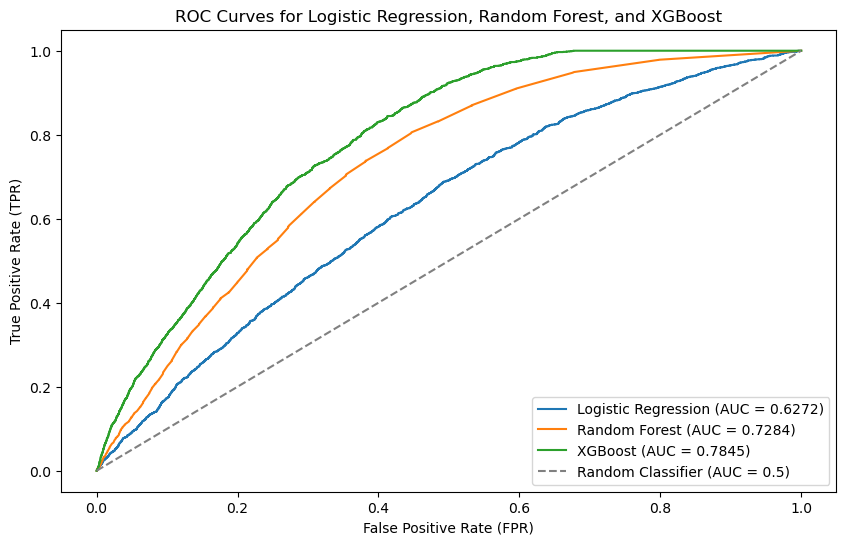

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate the ROC curve
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs_pos)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs_pos)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs_pos)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the ROC curve for each model
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_roc_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.4f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.4f})')

# Plot the diagonal line representing a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.5)')

# Customize the plot
plt.title('ROC Curves for Logistic Regression, Random Forest, and XGBoost')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [54]:
import lightgbm as lgb

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Get the probabilities for the positive class
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
lgb_roc_auc = roc_auc_score(y_test, lgb_probs)

# Calculate the ROC curve
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_probs)

# Create a plot
plt.figure(figsize=(12, 6))

# Plot the ROC curve for each model
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_roc_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.4f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.4f})')
plt.plot(lgb_fpr, lgb_tpr, label=f'LightGBM (AUC = {lgb_roc_auc:.4f})')

# Plot the diagonal line representing a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.5)')

# Customize the plot
plt.title('ROC Curves for Logistic Regression, Random Forest, XGBoost, and LightGBM')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show the plot
plt.show()


OSError: dlopen(/Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/alexeyefimik/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [55]:
import catboost as cb
from sklearn.metrics import roc_curve, auc

# Train the CatBoost model
cb_model = cb.CatBoostClassifier(random_seed=42, verbose=False)
cb_model.fit(X_train, y_train)

# Calculate probabilities for CatBoost
cb_probs = cb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_cb, tpr_cb, _ = roc_curve(y_test, cb_probs)

# Calculate AUC scores
auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_cb = auc(fpr_cb, tpr_cb)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()


ValueError: y should be a 1d array, got an array of shape (20000, 2) instead.

In [56]:
y

0        0
1        0
2        0
3        0
4        1
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: target, Length: 100000, dtype: int64

In [57]:
import catboost as cb
from sklearn.metrics import roc_curve, auc

# Train the CatBoost model
cb_model = cb.CatBoostClassifier(random_seed=42, verbose=False)
cb_model.fit(X_train, y_train)

# Calculate probabilities for CatBoost
cb_probs = cb_model.predict_proba(X_test)[:, 1]

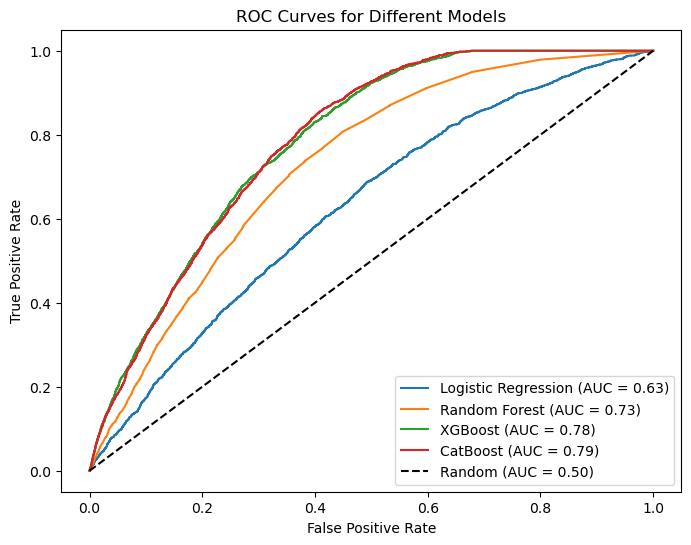

In [60]:
# Calculate ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_cb, tpr_cb, _ = roc_curve(y_test, cb_probs)

# Calculate AUC scores
auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_cb = auc(fpr_cb, tpr_cb)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()
